Let's assess a diode clipper circuit by transient and frequency analysis. The idea is to compare the obtained outputs from LTspice analysis (.tran and .ac) with our implementation in pywdf.

In [24]:
from pywdf.core.wdf import *
from pywdf.core.circuit import Circuit

from pathlib import Path
from sklearn.metrics import mean_squared_error


script_dir = Path().resolve()
ltspice_dir = script_dir.parent / "ltspice"


class DiodeClipper(Circuit):
    def __init__(
        self, sample_rate: int, cutoff: float = 1000, input_gain_db: float = 0,
        output_gain_db: float = 0, n_diodes: float = 2
    ) -> None:

        self.fs = sample_rate
        self.cutoff = cutoff
        self.input_gain = 10 ** (input_gain_db / 20)
        self.input_gain_db = input_gain_db
        self.output_gain = 10 ** (output_gain_db / 20)
        self.output_gain_db = output_gain_db

        self.C = 47e-9
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
        print(f"R: {self.R}")

        self.R1 = Resistor(self.R)
        self.Vs = ResistiveVoltageSource()

        self.S1 = SeriesAdaptor(self.Vs, self.R1)
        self.C1 = Capacitor(self.C, self.fs)

        self.P1 = ParallelAdaptor(self.S1, self.C1)
        self.Dp = DiodePair(self.P1, 2.52e-9, n_diodes=n_diodes)

        super().__init__(self.Vs, self.Dp, self.C1)

    def process_sample(self, sample: float) -> float:
        sample *= self.input_gain
        return -(super().process_sample(sample) * self.output_gain) ### ¡! phase inverted !¡

    def set_cutoff(self, new_cutoff: float) -> None:
        if self.cutoff != new_cutoff:
            self.cutoff = new_cutoff
            self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
            print(f"new resistance: {self.R}")
            self.R1.set_resistance(self.R)

    def set_input_gain(self, gain_db: float) -> None:
        if self.input_gain_db != gain_db:
            self.input_gain = 10 ** (gain_db / 20)
            self.input_gain_db = gain_db

    def set_output_gain(self, gain_db: float) -> None:
        if self.output_gain_db != gain_db:
            self.output_gain = 10 ** (gain_db / 20)
            self.output_gain_db = gain_db

    def set_num_diodes(self, new_n_diodes: float) -> None:
        if self.Dp.n_diodes != new_n_diodes:
            self.Dp.set_diode_params(self.Dp.Is, self.Dp.Vt, new_n_diodes)


Let's initialize a diode clipper with the same parameters than in our LTspice setup.

R: 33862.75384933943


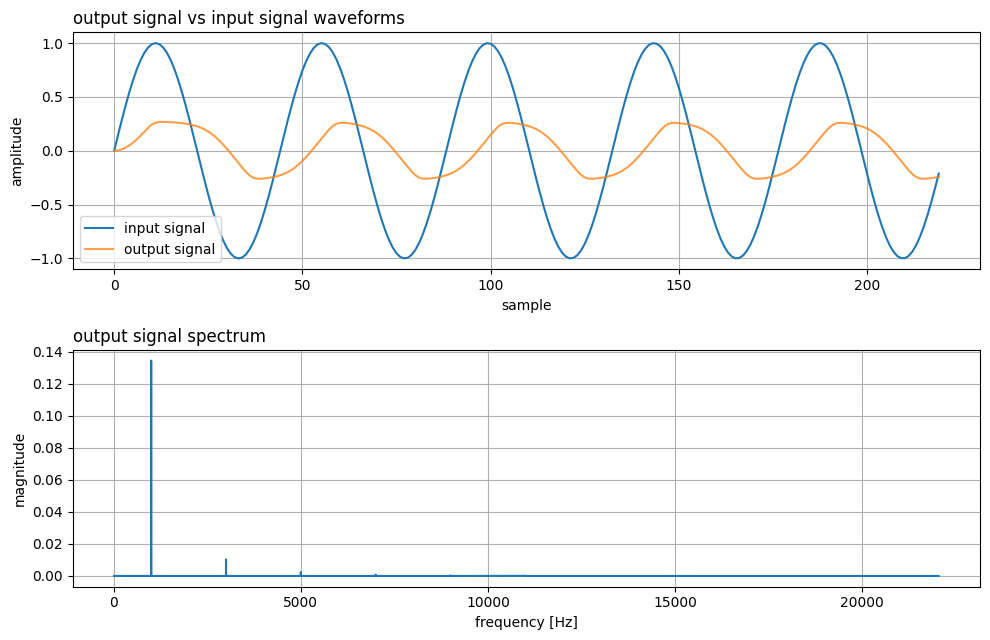

In [25]:
SAMPLE_RATE = 44100
cutoff = 100
input_gain = 10 # just to get 10V in the input
n_diodes = 1
diode_clipper = DiodeClipper(sample_rate=SAMPLE_RATE, cutoff=cutoff, input_gain_db=input_gain, n_diodes=n_diodes)
diode_clipper.set_cutoff(new_cutoff=cutoff)
diode_clipper.AC_transient_analysis()

Now, let's load the LTSpice data obtained after running the transient analysis in a 1d Diode Clipper with 100Hz cutoff 1st-order LPF RC filter.

In [26]:
import numpy as np
import matplotlib.pyplot as plt


ltspice_txt = ltspice_dir / "eval" / "diode-clipper-1d.txt"

The following method let us read the results of a transient analysis in a LTSpice TXT file.

In [ ]:
def load_ltspice_tran_anaylsis(file_path: Path) -> tuple:
    with open(file_path, 'r', encoding="utf-8") as f:
        # Read the contents of the file into a variable
        data = [line.strip().split() for line in f]

    # split header and convert timestamps and voltage values to floats
    header = data[0]
    data = data[1:]

    data = np.array([list(map(float, row)) for row in data])

    timestamps = data[:, 0]
    audio = data[:,1]

    return header, timestamps, audio

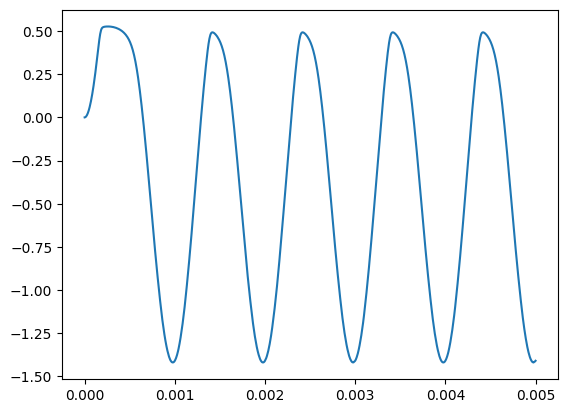

716
[0.00000000e+00 9.14285725e-07 1.82857145e-06 2.74285717e-06
 3.65714290e-06 4.57142862e-06 5.48571435e-06 6.40000007e-06
 1.12828126e-05 1.61656251e-05 2.10484376e-05 2.59312501e-05
 3.08140626e-05 3.56968751e-05 4.05796876e-05 4.54625001e-05
 5.03453126e-05 5.52281251e-05 6.01109376e-05 6.49937501e-05
 6.98765626e-05 7.47593751e-05 7.96421876e-05 8.45250001e-05
 8.94078126e-05 9.42906251e-05 9.91734376e-05 1.04056250e-04
 1.08939063e-04 1.13821875e-04 1.18704688e-04 1.23587500e-04
 1.28470313e-04 1.33353125e-04 1.38235938e-04 1.43118750e-04
 1.48001563e-04 1.52884375e-04 1.57767188e-04 1.62650000e-04
 1.67532813e-04 1.72415625e-04 1.77298438e-04 1.82181250e-04
 1.87064063e-04 1.91946875e-04 1.96829688e-04 2.01712500e-04
 2.06595313e-04 2.11478125e-04 2.16360938e-04 2.21243750e-04
 2.26126563e-04 2.31009375e-04 2.35892188e-04 2.40775000e-04
 2.45657813e-04 2.50540625e-04 2.55423438e-04 2.60306250e-04
 2.64491518e-04 2.68676786e-04 2.72862054e-04 2.77047322e-04
 2.81232589e-04 2.85

In [ ]:
header, ltspice_timestamps, ltspice_voltages = load_ltspice_tran_anaylsis(ltspice_txt)
plt.plot(ltspice_timestamps, ltspice_voltages)
plt.show()
print(len(ltspice_timestamps))
print(ltspice_timestamps)

Let's define the same input signal than in LTspice

In [7]:
t_ms = 5 # in milliseconds
frequency = 1000
n_samples = int(t_ms * SAMPLE_RATE / 1000)
print(n_samples)
n = np.linspace(0, t_ms / 1000, n_samples)
print(n)
input_signal = np.sin(2 * np.pi * frequency * n) * input_gain

220
[0.00000000e+00 2.28310502e-05 4.56621005e-05 6.84931507e-05
 9.13242009e-05 1.14155251e-04 1.36986301e-04 1.59817352e-04
 1.82648402e-04 2.05479452e-04 2.28310502e-04 2.51141553e-04
 2.73972603e-04 2.96803653e-04 3.19634703e-04 3.42465753e-04
 3.65296804e-04 3.88127854e-04 4.10958904e-04 4.33789954e-04
 4.56621005e-04 4.79452055e-04 5.02283105e-04 5.25114155e-04
 5.47945205e-04 5.70776256e-04 5.93607306e-04 6.16438356e-04
 6.39269406e-04 6.62100457e-04 6.84931507e-04 7.07762557e-04
 7.30593607e-04 7.53424658e-04 7.76255708e-04 7.99086758e-04
 8.21917808e-04 8.44748858e-04 8.67579909e-04 8.90410959e-04
 9.13242009e-04 9.36073059e-04 9.58904110e-04 9.81735160e-04
 1.00456621e-03 1.02739726e-03 1.05022831e-03 1.07305936e-03
 1.09589041e-03 1.11872146e-03 1.14155251e-03 1.16438356e-03
 1.18721461e-03 1.21004566e-03 1.23287671e-03 1.25570776e-03
 1.27853881e-03 1.30136986e-03 1.32420091e-03 1.34703196e-03
 1.36986301e-03 1.39269406e-03 1.41552511e-03 1.43835616e-03
 1.46118721e-03 1.48

In [8]:
# Lets process the signal with our wdf model redefining the input_gain and the sample rate to get the same signal lengths for both test signals
SAMPLE_RATE = 143525
input_gain = 1
diode_clipper = DiodeClipper(sample_rate=SAMPLE_RATE, cutoff=cutoff, input_gain_db=input_gain, n_diodes=n_diodes)
y_hat = diode_clipper(input_signal)

R: 33862.75384933943


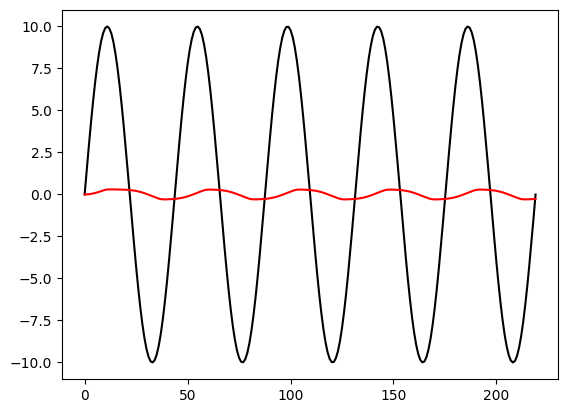

In [9]:
plt.plot(input_signal, 'k')
plt.plot(y_hat, 'r')
plt.show()

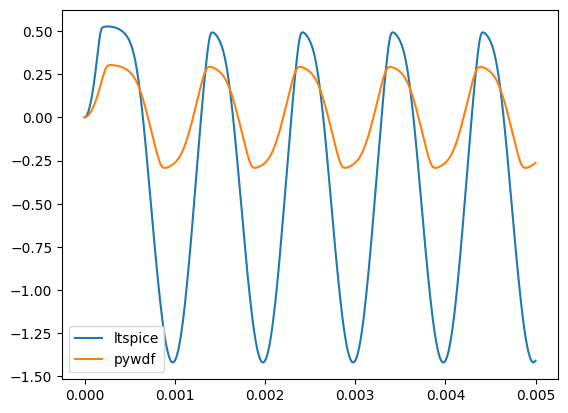

In [ ]:
plt.plot(ltspice_timestamps, ltspice_voltages, label="ltspice")
plt.plot(n, y_hat, label="pywdf")
plt.legend()
plt.show()

As we could observe the behaviour from LTSpice and pywdf versions of the Diode clipper have very different behaviour. They start to clip in a very different value and the negative cycles are always clipped when pywdf defines only one diode.

Let's do the same for an AC analysis that let us compare magnitude and phase from LTspice and pywdf circuits.

In [11]:
# loading frequency response from LTspice

ltspice_ac_analysis_txt = Path("/Users/xavierlizarraga/Documents/LTspice2/Draft12.txt")

In [ ]:
def load_ltspice_ac_analysis(file_path: Path) -> tuple:
    with open(file_path, 'r', encoding="latin") as f:
        # Read the contents of the file into a variable
        data = [line.strip().split() for line in f]
        # Print the names

    header = data[0]
    data = data[1:]

    # let's define some bins to store the data
    frequencies, magnitudes, phases = (list() for _ in range(3))

    for row in data:    # row[0] contains the frequency stamps and row[1] magnitude and phase
        frequency = row[0]
        magnitude_and_phase = row[1]
        #print(frequency, magnitude_and_phase)
        frequencies.append(float(row[0]))
        magnitude_and_phase = list(map(float, row[1][1:-2].split("dB,")))
        magnitudes.append(magnitude_and_phase[0])
        phases.append(magnitude_and_phase[1])

    frequencies = np.array(frequencies)
    magnitudes = np.array(magnitudes)
    phases = np.array(phases)

    return header, frequencies, magnitudes, phases

['Freq.', 'V(n002)']
fft_length: 14430


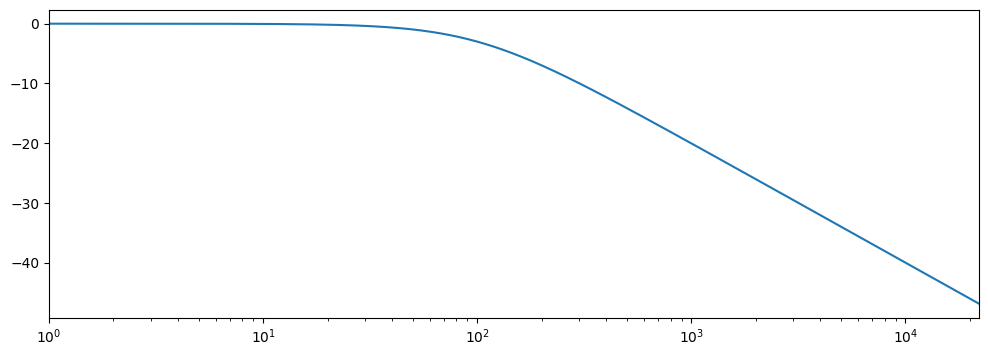

In [ ]:
header, lts_frequencies, lts_magnitudes, lts_phases = load_ltspice_ac_analysis(ltspice_ac_analysis_txt)
print(header)
print(f"fft_length: {len(lts_frequencies)}")
_, ax = plt.subplots(figsize=(12,4))
plt.semilogx(lts_frequencies, lts_magnitudes)
hearing_frequency_range = 22050
plt.xlim([10**0, hearing_frequency_range / 10000 * 10**4])
plt.show()

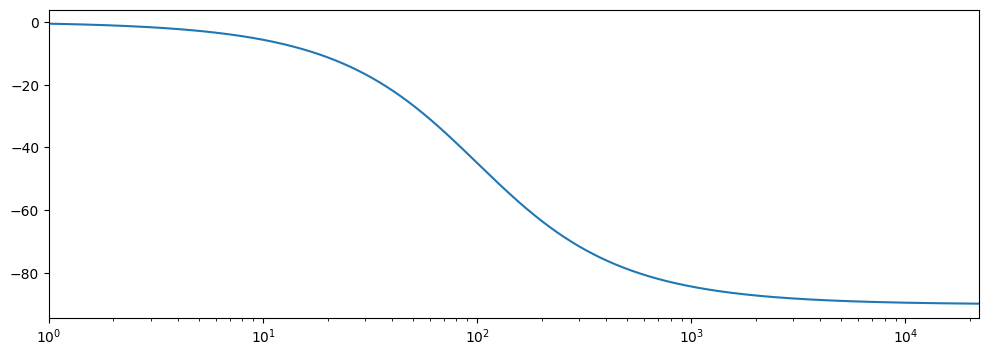

In [14]:
_, ax = plt.subplots(figsize=(12,4))
plt.semilogx(lts_frequencies, lts_phases)
plt.xlim([10**0, hearing_frequency_range / 10000 * 10**4])
plt.show()

In [15]:
diode_clipper.input_gain_db

1

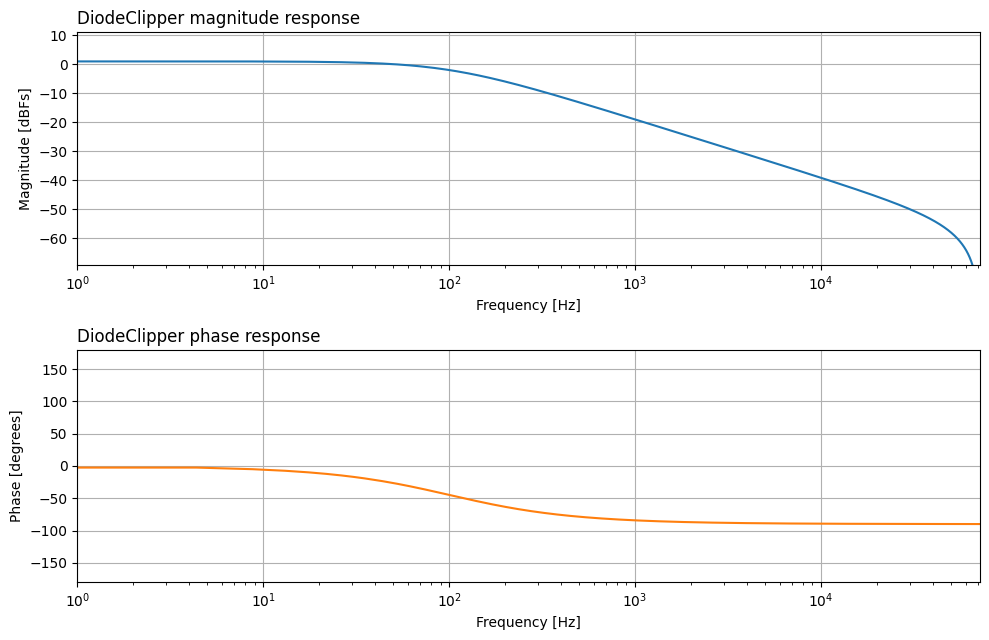

In [16]:
diode_clipper.plot_freqz()

In [ ]:
# let's get the same responses form pywdf virtualization

from scipy.fftpack import fft


# we need to define the test signal (dirac delta or impulse response)
def get_impulse_response(processor: object, sample_rate: int, delta_dur: float = 1, amp: float = 1) -> np.array:
    """Get circuit's impulse response

    Args:
        delta_dur (float, optional): duration of Dirac delta function in seconds. Defaults to 1.
        amp (float, optional): amplitude of delta signal's first sample. Defaults to 1.

    Returns:
        np.array: impulse response of the system
    """
    d = np.zeros(int(delta_dur * sample_rate))
    d[0] = amp
    return processor(d)

# We'll need to compute the spectrum
def compute_spectrum(processor: object, sample_rate: int, fft_size: int = None) -> np.ndarray:
    x = get_impulse_response(processor, sample_rate=sample_rate)
    N2 = int(fft_size / 2 - 1)
    H = fft(x, fft_size)[:N2]
    return H

SAMPLE_RATE = 44100
ltspice_fft_size = 28862
H = compute_spectrum(diode_clipper, SAMPLE_RATE, ltspice_fft_size)

# We'll need to estimate magnitude
magnitudes = 20 * np.log10(np.abs(H) + np.finfo(np.float16).eps)

# We'll need to estimate phase
phases = np.angle(H)

# We'll need some frequency stamps
frequencies = np.linspace(0, SAMPLE_RATE/2, int(ltspice_fft_size / 2 - 1))


In [18]:
print(len(frequencies))

14430


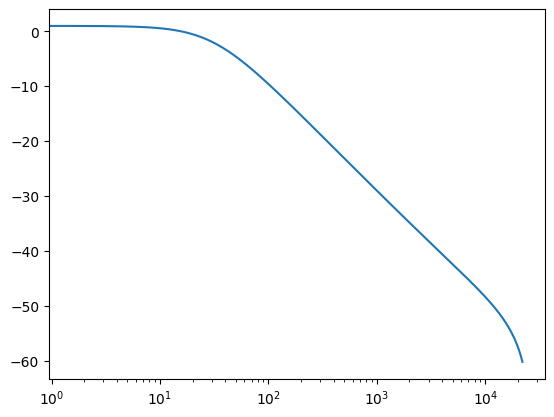

In [19]:
plt.semilogx(frequencies, magnitudes)
plt.show()

In [22]:
mean_squared_error(lts_magnitudes, magnitudes)

1292.1553058342188

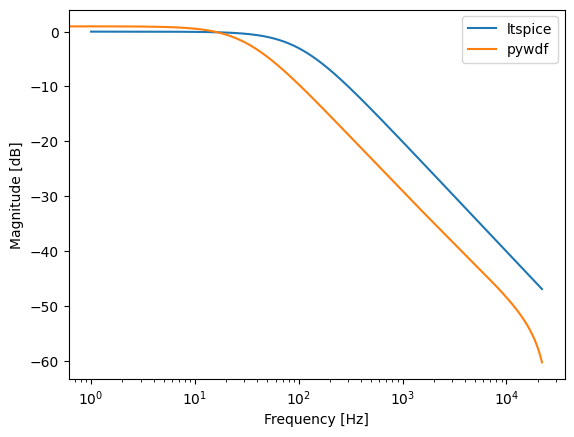

In [23]:
plt.semilogx(lts_frequencies, lts_magnitudes, label="ltspice")
plt.semilogx(frequencies, magnitudes, label = "pywdf")
plt.ylabel("Magnitude [dB]")
plt.xlabel("Frequency [Hz]")
plt.legend()
plt.show()

There is a mismatch in the cutoff frequency when we add the diode pair or it looks that the cutoff we obtain for pywdf is lower than expected if we compare with the LTSpice response.